# MACHINE LEARNING - CLASSIFICATION

In [1]:
import os
# Data management
import pandas as pd
# Math and Stat modules
import numpy as np
from scipy.special import logit, expit
from scipy import stats

# Data preprocessing and trasformation (ETL)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,precision_score, recall_score, f1_score,classification_report

#Supervised Learning
from sklearn.linear_model import LogisticRegression


# Unsupervised Learning

# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

## Prepare dataset

In [23]:
OPCUA_dataset = pd.read_csv('OPCUA_dataset_ML.csv')
OPCUA_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23450 entries, 0 to 23449
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             23450 non-null  int64  
 1   case_id                23450 non-null  object 
 2   IPclass                23450 non-null  object 
 3   stat_flags_mean        23450 non-null  float64
 4   stat_msg_size_mean     23450 non-null  float64
 5   stat_flowDuration_tot  23450 non-null  float64
 6   trace_is_fit_TR        23450 non-null  int64  
 7   trace_fitness_TR       23450 non-null  float64
 8   missing_tokens_TR      23450 non-null  int64  
 9   consumed_tokens_TR     23450 non-null  int64  
 10  remaining_tokens_TR    23450 non-null  int64  
 11  produced_tokens_TR     23450 non-null  int64  
 12  cost_AL                23450 non-null  int64  
 13  visited_states_AL      23450 non-null  int64  
 14  queued_states_AL       23450 non-null  int64  
 15  tr

In [24]:
OPCUA_dataset['label'].value_counts()

3    23376
2       49
1       19
4        6
Name: label, dtype: int64

In [25]:
OPCUA_dataset.drop(OPCUA_dataset.loc[24:14921].index, inplace=True) 
OPCUA_dataset.drop(OPCUA_dataset.loc[14972:23379].index, inplace=True) 

In [26]:
#LABEL 1 = Normal
OPCUA_dataset['label'].value_counts()

3    70
2    49
1    19
4     6
Name: label, dtype: int64

In [27]:
OPCUA_dataset.shape

(144, 19)

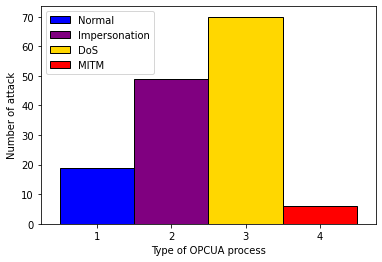

In [28]:
from matplotlib.patches import Rectangle
data = OPCUA_dataset['label']
vc = OPCUA_dataset.label.value_counts().sort_index()
# plot
colors = ['blue', 'purple', 'gold', 'red']
vc.plot(kind='bar', color=colors, width=1, rot=0, ec='k')    
plt.xlabel('Type of OPCUA process')
plt.ylabel('Number of attack')


handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
labels = ["Normal", "Impersonation", "DoS",'MITM']
plt.legend(handles, labels)   


In [29]:
OPCUA_dataset_label = OPCUA_dataset['label']

OPCUA_dataset.drop(columns=['Unnamed: 0',
                            'IPclass',
                            'trace_fitness_TR',
                            'case_id',
                            'trace_is_fit_TR',
                            'remaining_tokens_TR',
                            'produced_tokens_TR',
                            'label'],
                      inplace=True)

### Train Test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(OPCUA_dataset, OPCUA_dataset_label,
                                                    test_size = 0.3,
                                                    random_state = 0,
                                                    stratify=OPCUA_dataset_label)

### bringing features onto the same scale

In [31]:
PMAlgo_outputs_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
stats_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
category_pipeline = Pipeline([
    ('ordinal', OneHotEncoder())
])

In [11]:
OPCUA_dataset.columns

Index(['IPclass', 'stat_flags_mean', 'stat_msg_size_mean',
       'stat_flowDuration_tot', 'missing_tokens_TR', 'consumed_tokens_TR',
       'cost_AL', 'visited_states_AL', 'queued_states_AL', 'traversed_arcs_AL',
       'lp_solved_AL', 'fitness_AL'],
      dtype='object')

In [32]:
data_preprocessing = ColumnTransformer([
    ('stat_flags_mean', stats_pipeline, ['stat_flags_mean']),
    ('stat_msg_size_mean', stats_pipeline, ['stat_msg_size_mean']),
    ('stat_flowDuration_tot', stats_pipeline, ['stat_flowDuration_tot']),
    ('missing_tokens', PMAlgo_outputs_pipeline, ['missing_tokens_TR']),
    ('consumed_tokens', PMAlgo_outputs_pipeline, ['consumed_tokens_TR']),
    ('cost_AL', PMAlgo_outputs_pipeline, ['cost_AL']),
    ('visited_states', PMAlgo_outputs_pipeline, ['visited_states_AL']),
    ('queued_states', PMAlgo_outputs_pipeline, ['queued_states_AL']),
    ('traversed_arcs', PMAlgo_outputs_pipeline, ['traversed_arcs_AL']),
    ('lp_solved', PMAlgo_outputs_pipeline, ['lp_solved_AL']),
    ('fitness_AL', PMAlgo_outputs_pipeline, ['fitness_AL'])
],
    remainder = 'passthrough'
)

In [33]:
X_train_std = data_preprocessing.fit_transform(X_train)
X_test_std = data_preprocessing.transform(X_test)

In [34]:
X_train_std.shape

(100, 11)

In [35]:
X_test_std.shape

(44, 11)

## CHECK FEATURES IMPORTANCE (with ML Classifiers)

### check with LOGISTIC REGRESSION

In [36]:
lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# Note that C=1.0 is the default. You can increase
# or decrease it to make the regulariztion effect
# stronger or weaker, respectively.
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


In [37]:
lr.intercept_

array([-3.17719491, -1.09674057,  0.        , -4.09773779])

In [38]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

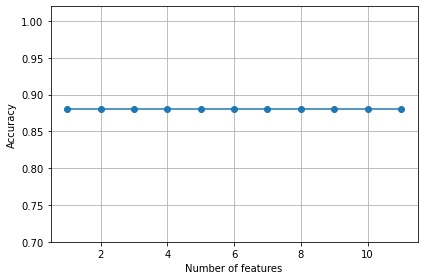

In [39]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [46]:
k3 = list(sbs.subsets_[7])
print(OPCUA_dataset.columns[0:][k3])

Index(['stat_flags_mean', 'stat_msg_size_mean', 'stat_flowDuration_tot',
       'missing_tokens_TR'],
      dtype='object')


In [47]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 0.9772727272727273


In [48]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.99
Test accuracy: 0.9545454545454546


### check with RANDOM FOREST

In [49]:
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(OPCUA_dataset, OPCUA_dataset_label,
                                                    test_size = 0.3,
                                                    random_state = 1,
                                                    stratify=OPCUA_dataset_label)

In [50]:
X_train_RF = data_preprocessing.fit_transform(X_train_RF)
X_test_RF= data_preprocessing.transform(X_test_RF)

In [51]:
X_train_RF.shape

(100, 11)

In [52]:
X_train_RF[1,:]

array([-0.45256964,  0.85286645, -0.31256391,  0.29488391, -0.3119203 ,
        0.34681046, -0.31178576, -0.31182553, -0.31182709, -0.2036872 ,
       -0.35156139])

In [54]:
feat_labels = OPCUA_dataset.columns[0:16]
feat_labels

Index(['stat_flags_mean', 'stat_msg_size_mean', 'stat_flowDuration_tot',
       'missing_tokens_TR', 'consumed_tokens_TR', 'cost_AL',
       'visited_states_AL', 'queued_states_AL', 'traversed_arcs_AL',
       'lp_solved_AL', 'fitness_AL'],
      dtype='object')

 1) stat_msg_size_mean             0.681780
 2) stat_flags_mean                0.144910
 3) traversed_arcs_AL              0.024663
 4) queued_states_AL               0.024392
 5) visited_states_AL              0.022919
 6) stat_flowDuration_tot          0.022517
 7) fitness_AL                     0.022199
 8) cost_AL                        0.022119
 9) consumed_tokens_TR             0.017108
10) lp_solved_AL                   0.014626
11) missing_tokens_TR              0.002767


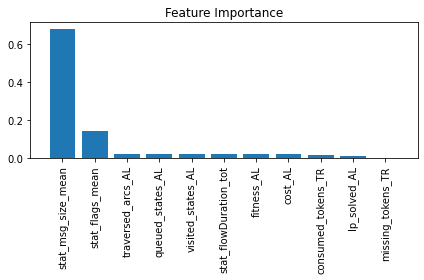

In [56]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = OPCUA_dataset.columns[0:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train_RF, y_train_RF)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train_RF.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train_RF.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train_RF.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train_RF.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

### VERIFY LINEAR CLASSIFICATION

In [61]:
OPCUA_dataset = pd.read_csv('OPCUA_dataset_ML.csv')
OPCUA_dataset_label = OPCUA_dataset['label']
normal_or_DoS = (OPCUA_dataset_label == 1) | (OPCUA_dataset_label == 3)
X_norm_dos = OPCUA_dataset[normal_or_DoS]
y_norm_dos = OPCUA_dataset_label[normal_or_DoS]
X_norm_dos.drop(columns=['Unnamed: 0',
                            'IPclass',
                            'trace_fitness_TR',
                            'case_id',
                            'trace_is_fit_TR',
                            'remaining_tokens_TR',
                            'produced_tokens_TR'],
                      inplace=True)

/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [64]:
X_norm_dos.head(20)

,stat_flags_mean,stat_msg_size_mean,stat_flowDuration_tot,missing_tokens_TR,consumed_tokens_TR,cost_AL,visited_states_AL,queued_states_AL,traversed_arcs_AL,lp_solved_AL,fitness_AL,label
0,1.0,226.746978,29.542159,0,6947,3472,13878,31231,34698,1,1.0,1
1,1.0,226.688742,29.563349,0,6945,3471,13874,31222,34688,1,1.0,1
2,1.0,226.682193,30.341139,0,7041,3519,14066,31654,35168,2,1.0,1
5,1.0,226.742119,30.290408,0,7041,3519,14066,31654,35168,2,1.0,1
9,1.0,226.865031,15.694721,0,3585,1791,7154,16102,17888,1,1.0,1
10,1.0,226.894590,15.325677,0,3585,1791,7154,16102,17888,2,1.0,1
11,1.0,226.883695,15.829652,0,3593,1795,7170,16138,17928,2,1.0,1
12,1.0,226.894268,15.524030,0,3593,1795,7170,16138,17928,2,1.0,1
13,1.0,226.880622,15.436899,0,3601,1799,7186,16174,17968,1,1.0,1
14,1.0,226.847307,15.594003,0,3601,1799,7186,16174,17968,1,1.0,1


Plotting the OPCUA data Normal vs DoS
--------------------------------------------------


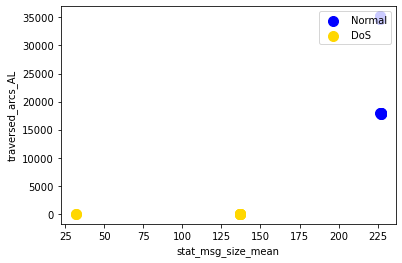

In [63]:
print(50 * '=')
print('Plotting the OPCUA data Normal vs DoS')
print(50 * '-')

# select values
y = OPCUA_dataset.iloc[0:20, 11].values
y = np.where(y == 1, -1, 1)

# extract 2 main features
X = X_norm_dos.iloc[0:20, [1, 8]].values

# plot data
plt.scatter(X[:10, 0], X[:10, 1],
            color='blue', marker='o',s=100, label='Normal')
plt.scatter(X[10:20, 0], X[10:20, 1],
            color='gold', marker='o',s=100, label='DoS')

plt.xlabel('stat_msg_size_mean')
plt.ylabel('traversed_arcs_AL')
plt.legend(loc='upper right')

# plt.tight_layout()
# plt.savefig('./images/02_06.png', dpi=300)
plt.show()

In [65]:
normal_or_MITM = (OPCUA_dataset_label == 1) | (OPCUA_dataset_label == 4)
X_norm_MITM = OPCUA_dataset[normal_or_MITM]
y_norm_MITM = OPCUA_dataset_label[normal_or_MITM]
X_norm_MITM.drop(columns=['Unnamed: 0',
                            'IPclass',
                            'trace_fitness_TR',
                            'case_id',
                            'trace_is_fit_TR',
                            'remaining_tokens_TR',
                            'produced_tokens_TR'],
                      inplace=True)


/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [66]:
X_norm_MITM.head(6)

,stat_flags_mean,stat_msg_size_mean,stat_flowDuration_tot,missing_tokens_TR,consumed_tokens_TR,cost_AL,visited_states_AL,queued_states_AL,traversed_arcs_AL,lp_solved_AL,fitness_AL,label
0,1.0,226.746978,29.542159,0,6947,3472,13878,31231,34698,1,1.000000,1
1,1.0,226.688742,29.563349,0,6945,3471,13874,31222,34688,1,1.000000,1
2,1.0,226.682193,30.341139,0,7041,3519,14066,31654,35168,2,1.000000,1
3,1.0,226.999071,9.289258,1,2147,21072,4285,9646,10716,3829,0.998150,4
4,1.0,227.885223,735.826626,3,4291,82142,8566,19274,21425,8591,0.996291,4
5,1.0,226.742119,30.290408,0,7041,3519,14066,31654,35168,2,1.000000,1


Plotting the OPCUA data Normal vs MITM
--------------------------------------------------


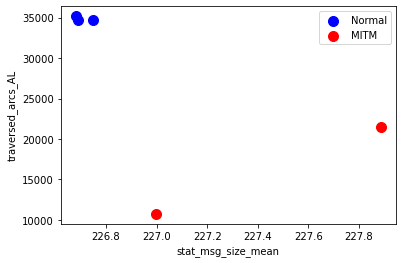

In [67]:
print(50 * '=')
print('Plotting the OPCUA data Normal vs MITM')
print(50 * '-')

# select values
y = OPCUA_dataset.iloc[0:5, 11].values
y = np.where(y == 1, -1, 1)

# extract 2 main features
X = X_norm_MITM.iloc[0:5, [1, 8]].values

# plot data
plt.scatter(X[:3, 0], X[:3, 1],
            color='blue', marker='o',s=100, label='Normal')
plt.scatter(X[3:5, 0], X[3:5, 1],
            color='red', marker='o',s=100, label='MITM')

plt.xlabel('stat_msg_size_mean')
plt.ylabel('traversed_arcs_AL')
plt.legend(loc='upper right')

# plt.tight_layout()
# plt.savefig('./images/02_06.png', dpi=300)
plt.show()

In [68]:
normal_or_Imp = (OPCUA_dataset_label == 1) | (OPCUA_dataset_label == 2)
X_norm_Imp = OPCUA_dataset[normal_or_Imp]
y_norm_Imp = OPCUA_dataset_label[normal_or_Imp]
X_norm_Imp.drop(columns=['Unnamed: 0',
                            'IPclass',
                            'trace_fitness_TR',
                            'case_id',
                            'trace_is_fit_TR',
                            'remaining_tokens_TR',
                            'produced_tokens_TR'],
                      inplace=True)

/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [69]:
X_norm_Imp.head(30)

,stat_flags_mean,stat_msg_size_mean,stat_flowDuration_tot,missing_tokens_TR,consumed_tokens_TR,cost_AL,visited_states_AL,queued_states_AL,traversed_arcs_AL,lp_solved_AL,fitness_AL,label
0,1.0,226.746978,29.542159,0,6947,3472,13878,31231,34698,1,1.0,1
1,1.0,226.688742,29.563349,0,6945,3471,13874,31222,34688,1,1.0,1
2,1.0,226.682193,30.341139,0,7041,3519,14066,31654,35168,2,1.0,1
5,1.0,226.742119,30.290408,0,7041,3519,14066,31654,35168,2,1.0,1
9,1.0,226.865031,15.694721,0,3585,1791,7154,16102,17888,1,1.0,1
10,1.0,226.894590,15.325677,0,3585,1791,7154,16102,17888,2,1.0,1
11,1.0,226.883695,15.829652,0,3593,1795,7170,16138,17928,2,1.0,1
12,1.0,226.894268,15.524030,0,3593,1795,7170,16138,17928,2,1.0,1
13,1.0,226.880622,15.436899,0,3601,1799,7186,16174,17968,1,1.0,1
14,1.0,226.847307,15.594003,0,3601,1799,7186,16174,17968,1,1.0,1


Plotting the OPCUA data - Normal vs Impersonation
--------------------------------------------------


/var/folders/v6/jrh7dpmj4rn6h4bw6xqfx5n40000gn/T/ipykernel_10542/1574027577.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y = np.where(y == 'Normal', -1, 1)


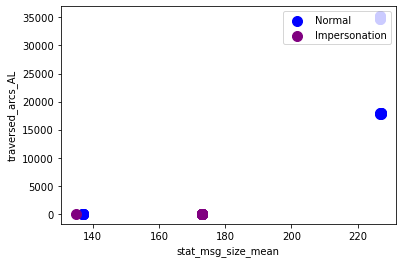

In [70]:
print(50 * '=')
print('Plotting the OPCUA data - Normal vs Impersonation')
print(50 * '-')

# select VALUES
y = X_norm_Imp.iloc[0:36, 11].values
y = np.where(y == 'Normal', -1, 1)

# extract 
X = X_norm_Imp.iloc[0:36, [1, 8]].values

# plot data
plt.scatter(X[:18, 0], X[:18, 1],
            color='blue', marker='o',s=100, label='Normal')
plt.scatter(X[18:36, 0], X[18:36, 1],
            color='purple', marker='o',s=100, label='Impersonation')

plt.xlabel('stat_msg_size_mean')
plt.ylabel('traversed_arcs_AL')
plt.legend(loc='upper right')

# plt.tight_layout()
# plt.savefig('./images/02_06.png', dpi=300)
plt.show()

### CHECK METRICS
- confusion matrix
- PCA features reduction

In [71]:
lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# Note that C=1.0 is the default. You can increase
# or decrease it to make the regulariztion effect
# stronger or weaker, respectively.
lr.fit(X_train_std, y_train)

LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear')

In [72]:
# make predictions with your classifier
y_pred = lr.predict(X_test_std) 

In [73]:
cnf_matrix = confusion_matrix(y_test, y_pred,labels=[1,2,3,4])
cnf_matrix

array([[ 6,  0,  0,  0],
       [ 0, 15,  0,  0],
       [ 0,  0, 21,  0],
       [ 0,  0,  0,  2]])

In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 6  0  0  0]
 [ 0 15  0  0]
 [ 0  0 21  0]
 [ 0  0  0  2]]


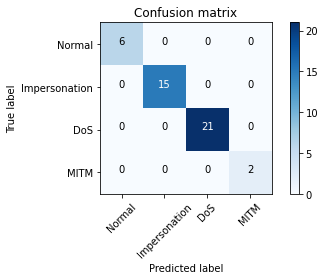

In [75]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Normal",'Impersonation',"DoS", "MITM"],
                      title='Confusion matrix')

In [76]:
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

       Normal       1.00      1.00      1.00         6
Impersonation       1.00      1.00      1.00        15
          DoS       1.00      1.00      1.00        21
         MITM       1.00      1.00      1.00         2

     accuracy                           1.00        44
    macro avg       1.00      1.00      1.00        44
 weighted avg       1.00      1.00      1.00        44



In [77]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^')
    colors = ('blue','purple','gold','red')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

/var/folders/v6/jrh7dpmj4rn6h4bw6xqfx5n40000gn/T/ipykernel_10542/983385781.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


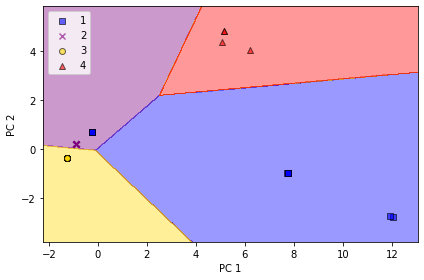

In [79]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

In [94]:
# make predictions with your classifier
y_pred = lr.predict(X_train_pca) 
cnf_matrix = confusion_matrix(y_train, y_pred,labels=[1,2,3,4])
cnf_matrix

array([[ 8,  5,  0,  0],
       [ 0, 34,  0,  0],
       [ 0,  0, 49,  0],
       [ 0,  0,  0,  4]])

In [95]:
print(classification_report(y_train, y_pred, target_names=labels))

               precision    recall  f1-score   support

       Normal       1.00      0.62      0.76        13
Impersonation       0.87      1.00      0.93        34
          DoS       1.00      1.00      1.00        49
         MITM       1.00      1.00      1.00         4

     accuracy                           0.95       100
    macro avg       0.97      0.90      0.92       100
 weighted avg       0.96      0.95      0.95       100



Confusion matrix, without normalization
[[ 8  5  0  0]
 [ 0 34  0  0]
 [ 0  0 49  0]
 [ 0  0  0  4]]


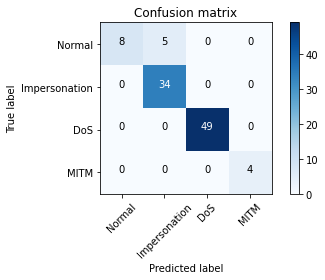

In [96]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Normal",'Impersonation',"DoS", "MITM"],
                      title='Confusion matrix')

/var/folders/v6/jrh7dpmj4rn6h4bw6xqfx5n40000gn/T/ipykernel_10542/983385781.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


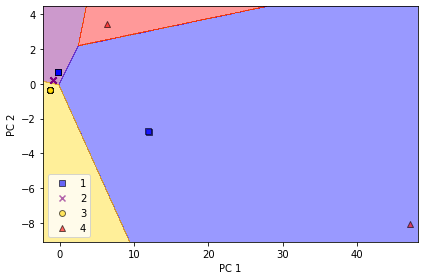

In [80]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

Confusion matrix, without normalization
[[ 2  4  0  0]
 [ 0 15  0  0]
 [ 0  0 21  0]
 [ 1  0  0  1]]


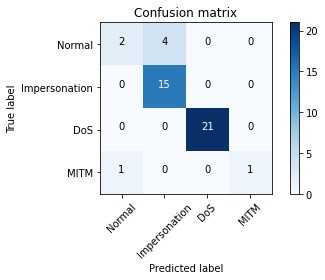

In [97]:
# make predictions with your classifier
y_pred = lr.predict(X_test_pca) 
cnf_matrix = confusion_matrix(y_test, y_pred,labels=[1,2,3,4])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Normal",'Impersonation',"DoS", "MITM"],
                      title='Confusion matrix')

In [98]:
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

       Normal       0.67      0.33      0.44         6
Impersonation       0.79      1.00      0.88        15
          DoS       1.00      1.00      1.00        21
         MITM       1.00      0.50      0.67         2

     accuracy                           0.89        44
    macro avg       0.86      0.71      0.75        44
 weighted avg       0.88      0.89      0.87        44



In [99]:
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X_train_pca, y_train)
y_pred = pipe_lr.predict(X_test_pca)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test_pca, y_test))

Test Accuracy: 0.886


In [100]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train_pca,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [1.  1.  0.9 0.9 1.  0.9 0.9 0.9 1.  1. ]
CV accuracy: 0.950 +/- 0.050


/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


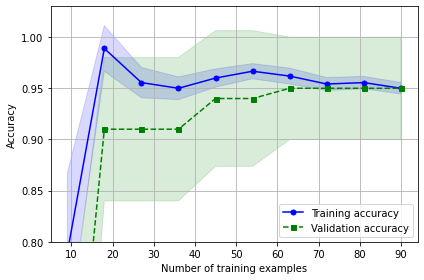

In [101]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train_pca,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


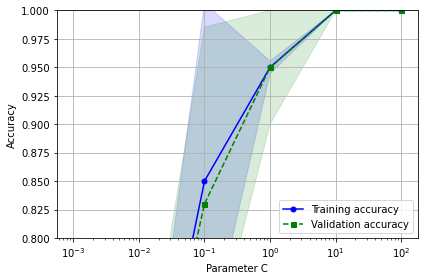

In [102]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train_pca, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train_pca, y_train)
print(gs.best_score_)
print(gs.best_params_)

/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


1.0
{'svc__C': 1.0, 'svc__kernel': 'linear'}


In [107]:
clf = gs.best_estimator_

# clf.fit(X_train, y_train) 
# note that we do not need to refit the classifier
# because this is done automatically via refit=True.

print('Test accuracy: %.3f' % clf.score(X_test_pca, y_test))

Test accuracy: 0.977


In [108]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train_pca, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


CV accuracy: 1.000 +/- 0.000


In [110]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X_train_pca, y_train)

/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

In [111]:
scores = cross_val_score(estimator=polynomial_svm_clf,
                         X=X_train_pca,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [1.  1.  0.9 0.9 1.  0.9 0.9 0.9 1.  1. ]
CV accuracy: 0.950 +/- 0.050


/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pmarincola/opt/anaconda3/envs/pm4pyEnv1/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increas